# Lecture 4

The **objective** of this lecture is to examine global emissions, introduce HTTP requests, and - briefly - to explain the structure of some geospatial data.  

In [2]:
import requests
import pandas
import matplotlib.pyplot as plt

## HTTP requests
Now, let's test this out with the NASA APIs.

There are eight requests methods. We just want to read information from the server.  We're not interested in putting or posting anything to a server.  The direction and type of information flow is pretty simple, and so we use the basic **GET** method.

In [39]:
# basic location, on the Internet, someone else's computer rather than ours locally
# like a directory.
url = "https://api.nasa.gov/planetary/apod"

print(requests.get(url))
print(requests.get(url).content)
print(requests.get(url).json())
print(requests.get(url, params={"api_key": "DEMO_KEY", "date": "2022-02-05"}))
# requests.get(url, params={"api_key": "DEMO_KEY", "date": "2022-02-05"}).url

<Response [403]>
b'{\n  "error": {\n    "code": "API_KEY_MISSING",\n    "message": "No api_key was supplied. Get one at https://api.nasa.gov:443"\n  }\n}'
{'error': {'code': 'API_KEY_MISSING', 'message': 'No api_key was supplied. Get one at https://api.nasa.gov:443'}}
<Response [200]>


This is an example of how to use the response data within a Notebook. 

In [40]:
# Retrieve the URL for an APOD image, and read the data in directly.
r = requests.get(url, params={"api_key": "DEMO_KEY", "date": "2022-02-06"}).json()
r["url"]

'https://apod.nasa.gov/apod/image/2202/bluemarble_apollo17_960.jpg'

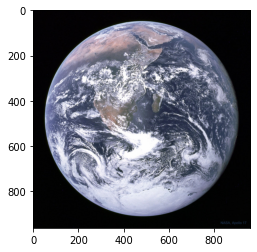

In [41]:
# plot the data directly from the URL, using built-in methods from Matplotlib
im = plt.imread(
    r["url"],
    format="jpg"
)

plt.imshow(im)

Not local.  Pulled directly from NASA's servers.  We use this technique often to find and explore data, quickly.  A pattern that we often used is the next-lvel hackathon.  Building something quickly with non-technical working groups, sometimes even live.  This ability to find and access data immediately is indispensable.

### A side note.  One of the most useful free APIs.
I use this often. OpenStreetMap (OSM) is a crowd-sourced map of the world. Nominatum is a web service that allows users to interact with OSM data. The input for the Nominatum geocoder is an address or a place name; the output is a latitude and longitude (and other OSM metadata).  The *reverse* geocoder accepts a latitude and longitude, and returns the place name and address - and sometimes even the boundary of the facility, if requested.

In [36]:
url = "https://nominatim.openstreetmap.org/reverse"
payload = {
    "format": "json",
    "lat": 37.8692322,
    "lon": -122.25755
}
requests.get(url, params=payload).json()

{'place_id': 282643994,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'relation',
 'osm_id': 1734951,
 'lat': '37.86959085',
 'lon': '-122.25660784649196',
 'display_name': 'Hearst Memorial Gymnasium, Bancroft Way, Southside, Berkeley, Alameda County, California, 94720-1076, United States',
 'address': {'leisure': 'Hearst Memorial Gymnasium',
  'road': 'Bancroft Way',
  'neighbourhood': 'Southside',
  'city': 'Berkeley',
  'county': 'Alameda County',
  'state': 'California',
  'postcode': '94720-1076',
  'country': 'United States',
  'country_code': 'us'},
 'boundingbox': ['37.8691627', '37.8700195', '-122.2575961', '-122.2562433']}

In [ ]:
# Find and plot the boundary for the Hearst Memorial Gymnasium 
# using https://geojson.io
url = "https://nominatim.openstreetmap.org/reverse"
payload = {
    "format": "json",
    "lat": 37.8692322,
    "lon": -122.25755,
    "polygon_geojson": 1
}
r = requests.get(url, params=payload).json()

## Finding data in the console
The `requests` package allows access to data.  How do we *find* the data we want to access.  Often, websites will rely on data.  Let's try to find data by looking inside the developer console.  [This was a helpful article](https://support.monday.com/hc/en-us/articles/360002197259-How-to-Open-the-Developer-Console) on how to open the developer console in different browsers.

In [ ]:
url = "https://global-coal-map-2020.s3.eu-west-2.amazonaws.com/data/coal2020.geojson"
r = requests.get(url)

The GeoJSON format is a particular fromat for JSON.  There are properties associated with each `feature`, represented as a dictioary.

In [ ]:
res = r.json()
features = res["features"]

In [ ]:
len(features)
features[0]

In [36]:
# strip out the type and geometry of each feature
# count the number of features - in this case, each feature represets a coal-fired powerplant 
# in the dataset.
rows = [f["properties"] for f in features]
df = pandas.DataFrame(rows)
df.head()

5370

<BarContainer object of 10 artists>

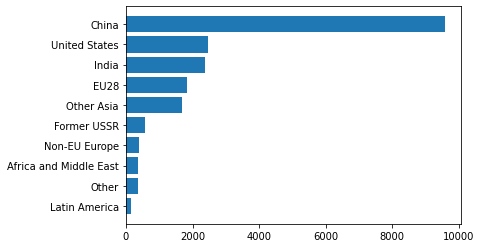

In [53]:
# some are operating, some are not
operating = df[df.status == "Operating"]
operating.groupby("coalType")["annualCarbon"].sum()
hist_data = operating.groupby("regionLabel")["annualCarbon"].sum()
hist_data = hist_data.reset_index().sort_values("annualCarbon")
plt.barh(hist_data.regionLabel, hist_data.annualCarbon)

In [81]:
# # some are operating, some are not
print(set(df.status))
other = df[df.status != "Operating"]
other.groupby("regionLabel")["annualCarbon"].sum()

{'Permitted', 'Operating', 'Announced', 'Construction', 'Pre-permit'}


regionLabel
Africa and Middle East    142.62
China                     864.77
EU28                       31.74
Former USSR                28.11
India                     276.97
Latin America              11.50
Non-EU Europe             180.28
Other                      12.88
Other Asia                581.21
Name: annualCarbon, dtype: float64

## Working with TRACE data
Putting it together.  Real data with specific, custom requests.

> Climate TRACE’s emissions inventory is the world’s first comprehensive accounting of GHG emissions based primarily on direct, independent observation. Our innovative, open, and accessible approach relies on advances in technology to fill critical knowledge gaps for all countries that rely on the patchwork system of self-reporting that serves as the basis for most existing emissions inventories.

The api is not well-documented yet (our team is working on it) but the auto-documentation can be found at [api.climatetrace.org](https://api.climatetrace.org/)

In [55]:
url = "https://api.climatetrace.org/emissions_by_sector"
payload = {
    "country": "USA",
    "since": "2010",
    "to": "2020"
}

res = requests.get(url, params=payload)
res.json()

[{'name': 'agriculture',
  'last_updated': '2020-12-31',
  'total': 2390000472.062,
  'subsectors': [{'name': 'rice cultivation', 'total': 32616437.904},
   {'name': 'enteric fermentation', 'total': 1006812836.4},
   {'name': 'manure management', 'total': 322066052.8},
   {'name': 'cropland fires', 'total': 48424068.758},
   {'name': 'managed soils', 'total': 980081076.2}]},
 {'name': 'buildings',
  'last_updated': '2020-12-31',
  'total': 4428532960.4,
  'subsectors': [{'name': 'refrigeration air conditioning',
    'total': 934862996.4},
   {'name': 'cooking', 'total': 19881164},
   {'name': 'residential commercial onsite heating', 'total': 3473788800}]},
 {'name': 'extraction',
  'last_updated': '2020-12-31',
  'total': 20561122.0,
  'subsectors': [{'name': 'bauxite mining', 'total': 11754},
   {'name': 'coal mining', 'total': None},
   {'name': 'sand quarry', 'total': 1627886},
   {'name': 'rock quarry', 'total': 8502534},
   {'name': 'copper mining', 'total': 8382858},
   {'name': 

In [65]:
r = [x["total"]for x in res.json() if x["name"] == "forests"]

[3958941038.718]

In [6]:
def get_forest_emissions(country_code):
    """
    A function that accepts a three-character country code and 
    returns aggregate forest emissions from 2010-2020
    """
    url = "https://api.climatetrace.org/emissions_by_sector"
    payload = {
        "country": country_code,
        "since": "2010",
        "to": "2020"
    }

    res = requests.get(url, params=payload)
    
    # destructure `[...]` the response so that the result is a 
    # number, not a list 
    [r] = [x["total"]for x in res.json() if x["name"] == "forests"]
    return r

get_forest_emissions("USA")

3958941038.718

In [7]:
[get_forest_emissions(x) for x in ["USA", "CHN", "IDN", "BRA"]]

[3958941038.718, 1105471493.984, 2494997045.912, 7415473454.002]